In [62]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [63]:
train_df = pd.read_csv('dataset/train.csv')
train_df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_df.drop(columns=['id', 'Heart Disease']), train_df['Heart Disease'])

In [65]:
import numpy as np

def apply_bins(series, bin_edges):
    return (pd.cut(series, bins=bin_edges, labels=False, include_lowest=True)
            .clip(lower=0, upper=len(bin_edges) - 2)
            .astype(int) + 1
    )

num_bins = 5
bin_edges = np.linspace(start=X_train['Age'].min(), stop=X_train['Age'].max(), num=num_bins + 1)
X_train['Age Bin'] = apply_bins(X_train['Age'], bin_edges)
X_test['Age Bin'] = apply_bins(X_test['Age'], bin_edges)

In [66]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

columns_to_remove = [
  'Age'
]

X_train = X_train.drop(columns=columns_to_remove)
X_test= X_test.drop(columns=columns_to_remove)

test_label_encoder = LabelEncoder()
Y_train = pd.Series(test_label_encoder.fit_transform(Y_train), index=Y_train.index, name='Heart Disease')
Y_test = pd.Series(test_label_encoder.transform(Y_test), index=Y_test.index, name='Heart Disease')

standard_scalers = {}
for col in X_train.columns:
  standard_scaler = StandardScaler()
  X_train[col] = standard_scaler.fit_transform(np.array(X_train[col]).reshape(-1, 1))
  X_test[col] = standard_scaler.transform(np.array(X_test[col]).reshape(-1, 1))
  standard_scalers[col] = standard_scaler

In [67]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgboost = XGBClassifier(objective='binary:logistic', eval_metric='auc')

param_grid = [
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200]
    },
    {
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.1, 1, 10],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [100, 200]
    },
    {
        'penalty': ['none'],
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'max_iter': [100, 200]
    }
]


grid_search_cv = GridSearchCV(xgboost, param_grid=param_grid, scoring='roc_auc')
grid_search_cv.fit(X_train, Y_train)
print(grid_search_cv.best_params_)

predictions = grid_search_cv.predict(X_test)

{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [68]:
def predict_based_on_threshold(model: GridSearchCV, threshold: float, test_data: pd.DataFrame):
  probabilities = model.predict_proba(test_data)[:, 1]
  return (probabilities >= threshold).astype(int)

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

threshold_roc_list = []
for threshold in np.arange(0.05, 1.05, 0.05):
  predictions = predict_based_on_threshold(grid_search_cv, threshold, X_test)
  print('===Accuracy===')
  print(accuracy_score(Y_test, predictions))

  print('\n===Precision===')
  print(precision_score(Y_test, predictions))

  print('\n===Recall===')
  print(recall_score(Y_test, predictions))

  print('\n===ROC AUC===')
  score = roc_auc_score(Y_test, predictions)
  print(score)

  threshold_roc_list.append(tuple([float(threshold), score]))

print(sorted(threshold_roc_list, key=lambda x: x[1], reverse=True))

===Accuracy===
0.7279682539682539

===Precision===
0.6239251096186437

===Recall===
0.987174758107993

===ROC AUC===
0.7525859310111529
===Accuracy===
0.8006095238095238

===Precision===
0.6992596973528572

===Recall===
0.9728882331243084

===ROC AUC===
0.8169713880357102
===Accuracy===
0.8351238095238095

===Precision===
0.7453160818197849

===Recall===
0.9594387537950799

===ROC AUC===
0.8469304004109974
===Accuracy===
0.854615873015873

===Precision===
0.7775587336397359

===Recall===
0.9456771557472405

===ROC AUC===
0.8632642565000482
===Accuracy===
0.8673142857142857

===Precision===
0.8024912768708977

===Recall===
0.933192407002809

===ROC AUC===
0.8735709431984647
===Accuracy===
0.8759365079365079

===Precision===
0.823261421319797

===Recall===
0.9203671651108022

===ROC AUC===
0.8801562306350204
===Accuracy===
0.8819365079365079

===Precision===
0.8409619554504238

===Recall===
0.9078824163663707

===ROC AUC===
0.8844006744759658
===Accuracy===
0.885663492063492

===Precisio

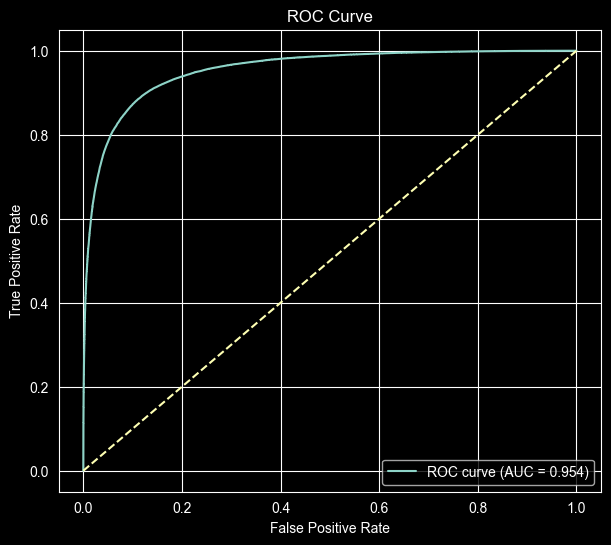

In [70]:
import matplotlib.pyplot as plt

y_probs = grid_search_cv.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [76]:
sub_df = pd.read_csv('dataset/test.csv')
sub_ids = sub_df['id']

sub_df['Age Bin'] = apply_bins(sub_df['Age'], bin_edges)
sub_df = sub_df.drop(columns=columns_to_remove + ['id'])

for col in sub_df.columns:
  sub_df[col] = standard_scalers.get(col).transform(np.array(sub_df[col]).reshape(-1, 1))

sub_predictions = grid_search_cv.predict(sub_df)
pd.concat([sub_ids, pd.DataFrame(sub_predictions)], axis=1).to_csv("predictions.csv", index=False, header=['id', 'Heart Disease'])